# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (1er entrega)

## Fecha de entrega

*Ingresar fecha*

## Integrantes

* Juan, Aldrey
* Nicolás Ariel, Fontenla
* Ezequiel Nicolás, Bordone

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la funcion de ejemplo (`ruidoRosa_voss`).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) (con las celdas ejecutas) y todos los archivos para reproducir los resultados por Slack.
* Todas las señales de audio deben ser generadas en formato .wav en una función nueva.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.io import wavfile
import pyaudio
import sounddevice as sd
import soundfile as sf
import wave

## Función de sintetización de ruido rosa
El ruido rosa o ruido $\frac{1}{\sqrt{f}}$ , dónde $f$ denota frecuencia en Hz, es un ruido con una distribución de frecuencias tal que su densidad espectral de potencia es proporcional a la inversa de la frecuencia. Esto implica que su nivel, por bandas de tercio de octava, es constante. El nivel del ruido rosa por intervalo fijo de frecuencias va decayendo a razón de 3 dB/octava, de forma no lineal aunque las frecuencias se representan en un eje lineal.

![Espectro del ruido rosa](media/image44.png)

<center><b>Fig 1.</b> Espectro del ruido rosa.</center>

Se adjunta a continuación una función que devuelva un ruido rosa sintetizado a partir del algoritmo de Voss y Clarke (pueden encontrar mas informacion en [este enlace](https://www.dsprelated.com/showabstract/3933.php) y en [este notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)). 

**Consigna:** modificar la función original para que reciba como parametro la duración del ruido en segundos $t$ y como parametro opcional la frecuencia de muestreo $fs$ (Ayuda: la longitud de la señal sera el producto entre ambos). La función debe guardar el archivo de audio .wav de la señal generada y devolver el vector de datos de la señal.

In [2]:
def ruidoRosa_voss_v2(t, fs=44100):

    """
    
    Esta función implementa la versión 2 del método de Voss para generar ruido rosa,
    el cual se caracteriza por tener la misma densidad espectral de potencia por 
    cada octava de frecuencia.

    ¿Cómo lo hace?
        * Transforma todas más muestras obtenidas a partir de multiplicar la frecuencia de
            muestreo (fs) por los segundos en columnas de una matriz.
        * Otorga valores aleatorios a cada una de esas muestras y las asigna a una fila de
            dicha matriz.
        * Genera la matriz a partir de dicha información.
        * Genera un archivo WAV a partir de la matriz, que contiene el ruido rosa generado, 
            normalizado.

    Parámetros:
        t (float): Duración del ruido rosa en segundos.
        fs (int, opcional): Frecuencia de muestreo del ruido rosa (Hz). 
            Por defecto es 44100 Hz.

    Retorno:
        ndarray: Arreglo de NumPy que representa el ruido rosa generado.

    """
    
    nrows = fs * t
    ncols = 16
    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # el numero total de cambios es nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)
    
    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1)
    
    ## Centrado de el array en 0
    total = total - total.mean()
    
    ## Normalizado
    valor_max = max(abs(max(total)),abs(min(total)))
    total = total / valor_max
    
    # Agregar generación de archivo de audio .wav
    wavfile.write("media/ruidoRosa.wav", fs, np.int16(total * 32767))

    return total

Llamar la función.

In [3]:
ruidoRosa = ruidoRosa_voss_v2(10)


C:\Users\juana\AppData\Local\Temp\ipykernel_34052\3438079455.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled = df.fillna(method='ffill', axis=0)


Realizar una función para visualizar el dominio temporal de la señal.

In [4]:
def dominioTemporal(señal, fs=44100):

    """
    Permite visualizar el ruido rosa en el dominio temporal.

    Parámetros:
        señal (ndarray): Señal de audio a visualizar.
        fs (int, opcional): Frecuencia de muestreo (Hz). Predeterminada: 44100 Hz.

    """

    vectorTemporal = np.arange(0, len(señal) * 1/fs, 1/fs) 
    # Donde 1/fs es el periodo se sampleo, es decir el tiempo entre muestras

    plt.plot(vectorTemporal, señal)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title('Ruido Rosa')
    plt.grid(True)
    plt.show()

Llamar a la función.

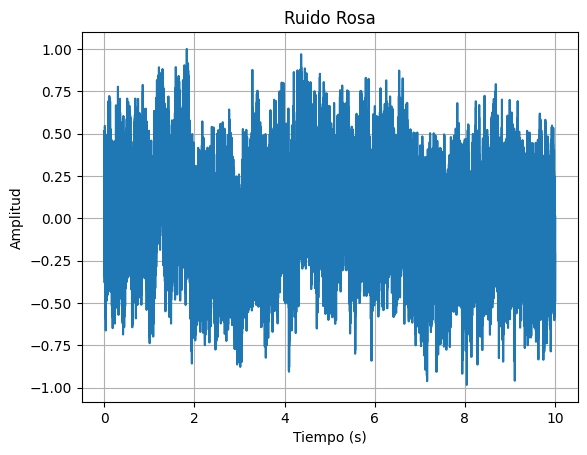

In [5]:
dominioTemporal(ruidoRosa)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

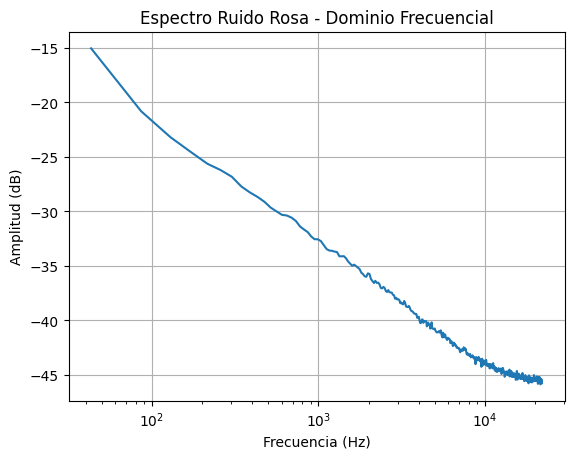

In [6]:
# OPCION INTERACTIVA PARA COMPARAR DOS FRECUENCIAS SEPARADAS POR UNA OCTAVA

df = pd.read_csv("media/espectro-ruido-rosa.txt", sep='\t', skiprows=1, header=None)

while True:
    opcion = input("Si desea ver el espectro entre 1000 y 2000 hz pulse (y)").lower()
    if opcion in ('y'):
        plt.plot(df.iloc[:, 0], df.iloc[:, 1])
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Amplitud (dB)')
        plt.xscale('log')
        plt.xlim(1000, 2000)
        plt.ylim(-36,-32)
        plt.title('Espectro Ruido Rosa - Dominio Frecuencial - Espectro entre 1000 y 2000 Hz')
        plt.grid(True)
        plt.show()
        break
    else:
        plt.plot(df.iloc[:, 0], df.iloc[:, 1])
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Amplitud (dB)')
        plt.xscale('log')
        plt.title('Espectro Ruido Rosa - Dominio Frecuencial')
        plt.grid(True)
        plt.show()
        break
      

    Frequency (Hz)  Level (dB)
23      1033.59375  -32.729717


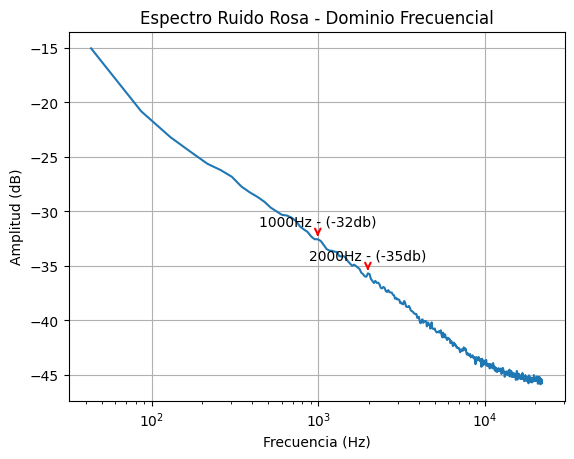

In [7]:
# OPCION NORMAL SIN COMPARACION

df = pd.read_csv("media/espectro-ruido-rosa.txt", sep='\t', header=0)

plt.plot(df.iloc[:, 0], df.iloc[:, 1])
print(df[df['Frequency (Hz)'] == 1033.593750])
plt.annotate("1000Hz - (-32db)", (990.527344, -32.566341), textcoords="offset points", xytext=(0, 10), ha='center', arrowprops=dict(arrowstyle="->", color='red', lw=1.5))
plt.annotate("2000Hz - (-35db)", (1981.054688, -35.690636), textcoords="offset points", xytext=(0, 10), ha='center', arrowprops=dict(arrowstyle="->", color='red', lw=1.5))
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.xscale('log')
plt.title('Espectro Ruido Rosa - Dominio Frecuencial')
plt.grid(True)
plt.show()

Reproducir resultado.

In [8]:
# Reproducir ruido rosa
sd.play(ruidoRosa)
sd.wait()

KeyboardInterrupt: 

> Solo a modo de comentario, un **método alternativo** es utilizando un filtro en el siguiente [link](https://ccrma.stanford.edu/~jos/sasp/Example_Synthesis_1_F_Noise.html) se presenta la implementación en Matlab/Octave.

## Funcion de generación de sine sweep logaritmico + filtro inverso
El sine sweep es el método más indicado para generar el impulso por medio de la convolución (Nikolić, I., and O. H. Bjor, 2003). Dado que métodos tales como: explosión de globo, aplauso, disparo con pistola se salva, paper gun ([Paper Popper](https://en.wikipedia.org/wiki/Paper_popper)), golpe entre maderas, petardos, entre otros, carecen de reproducibilidad. Esto es debido a su nivel sonoro, duración y características espectrales, además de una muy baja relación señal ruido, la cual difícilmente se solucione filtrando o promediando con muchas mediciones. Comencemos por ver cómo generar el sine sweep logarítmico $x(t)$ que posee la siguiente forma:

\begin{equation}
f(x) = \sin[\theta(t)]= \sin[K (e^\frac{t}{L} - 1) ]
\tag{1}
\end{equation}

Donde:

\begin{equation}
K = \frac{T w_{1}}{R}
\end{equation}

\begin{equation}
L = \frac{T}{R}
\end{equation}

y el sweep rate $R$: 

\begin{equation}
R = \ln \left( \frac{w_{2}}{w_{1}} \right)
\tag{2}
\end{equation}

Con $w_{1}$ y $w_{2}$, las frecuencias angulares inferior y superior respectivamente, $T$ es el tiempo de duración del sine sweep en segundos (Meng, Q., 2008). Si estudiamos el espectro de la señal de la ecuación (1), se observa que no es plano, sino que disminuye a razón de -3 dB/octava, como el ruido rosa (Ver fig. 2, sup). De modo que el espectro de $x(-t)$ debe ser ajustado, aumentando en 3 dB/octava, de modo que cuando realizamos el cálculo se restaure la plenitud perfecta de la respuesta de impulso medida $h(t)$ (Farina A., 2000) (Ver fig. 2, inf).

![](media/image43.png)
<center><b>Fig 2.</b> Espectro del sine sweep. Sine sweep logarítmico  (sup). Filtro invertido (inf).</center>


En el dominio temporal las señales del sine sweep logarítmico y el filtro inverso se comportan de la siguiente manera (Ver fig. 3). 

![](media/image46.png)
<center><b>Fig 3.</b> Magnitud del sine sweep. Sine sweep logarítmico (sup). Filtro invertido (inf).</center>

Para generar el filtro inverso $k(t)$ del sine sweep logarítmico $x(t)$ se requiere de una modulación $m(t)$ definida por la siguiente expresión:

\begin{equation}
m(t) = \frac{w_{1}}{2\pi w(t)}
\tag{3}
\end{equation}

Obtenida de la frecuencia instantánea (dado que la amplitud cambia en función de la
frecuencia), calculada a partir de la ecuación (1):

\begin{equation}
w(t)=\frac{d[\theta (t)]}{dt}=\frac{K}{L} e^\frac{t}{L}
\tag{4}
\end{equation}
m
entonces, el filtro inverso $k(t)$ queda definido como:

\begin{equation}
k(t)=m(t)x(-t)
\tag{5}
\end{equation}

**Consigna:** realizar una función generadora de un sine sweep y su filtro inverso, a partir de las ecuaciones descriptas anteriormente, y graficar el resultado de ambos filtros, usando la función anteriormente creada. Recordar almacenar los audios. Agregar docstring que indique claramente los parametros de entrada y salida.

In [1]:

def generarSineSweepYFiltroInverso(finf, fsup, t0):

    """
    Genera un sine sweep (barrido sinusoidal) y su filtro inverso.

    Esta función genera un barrido sinusoidal que incrementa su frecuencia 
    desde una frecuencia inicial (`finf`) hasta una frecuencia final (`fsup`) 
    en un tiempo determinado (`t0`). También calcula su filtro inverso.

    ¿Cómo lo hace?:
        Genera dos archivos WAV: "media/sine-sweep.wav" y "media/filtro-inverso.wav" 
        que contienen el barrido sinusoidal y el filtro inverso respectivamente, 
        normalizados y con una frecuencia de muestreo de 44100 Hz.

    Parámetros:
        finf, fsuy y t0, siendo los tres float que representan la frecuencia inicial,
        final (expresadas en Hz) y la duración (en segundos) del barrido respectivamente.

    Retorno:
        Una tupla que contiene: sine_sweep, filtro_inverso y t, siendo los tres arreglos
        de numpy que representan el barrido sinusoidal, el filtro inverso y el eje temporal
        respectivamente.

    """

    wi = 2*np.pi*finf
    ws = 2*np.pi*fsup

    R = np.log(ws/wi)
    K = (t0*wi)/R
    L = t0/R
    fs = 44100
    t = np.linspace(0,t0,t0*fs)

    # Definición del sine sweep
    sine_sweep = np.sin(K*(np.exp(t/L)-1))
    sine_sweep = sine_sweep * 0.5 # para equiparar las amplitudes del sine sweep y el filtro inverso

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(t, sine_sweep)
    ax1.set_ylabel('Amplitud')
    ax1.set_title('Sine Sweep')
    ax1.grid(True)

    # Definición de la modulacion
    m = wi/(2*np.pi*(K/L)*np.exp(t/L))  # (K/L)*math.exp(t/L) = w(t) en la consigna

    # Definición del filtro inverso
    filtro_inverso = m*sine_sweep[::-1]
    filtro_inverso = filtro_inverso * 5 # para equiparar las amplitudes del sine sweep y el filtro inverso

    ax2.plot(t, filtro_inverso)
    ax2.set_ylabel('Amplitud')
    ax2.set_title('Filtro Inverso')
    ax2.grid(True)

    plt.xlabel('Tiempo (s)')
    fig.suptitle('Sine Sweep y Filtro Inverso - Dominio Temporal')

    sf.write("media/sine-sweep.wav", sine_sweep, samplerate=fs)
    sf.write("media/filtro-inverso.wav", filtro_inverso, samplerate=fs)

    return (sine_sweep, filtro_inverso, t)


Llamar la función.

(array([ 0.        ,  0.07099749,  0.14055651, ..., -0.06726586,
        -0.47824757, -0.33233186]),
 array([-0.26446129, -0.38057553, -0.05352796, ...,  0.01398155,
         0.00706228,  0.        ]),
 array([0.00000000e+00, 2.26757884e-05, 4.53515768e-05, ...,
        9.99995465e+00, 9.99997732e+00, 1.00000000e+01]))

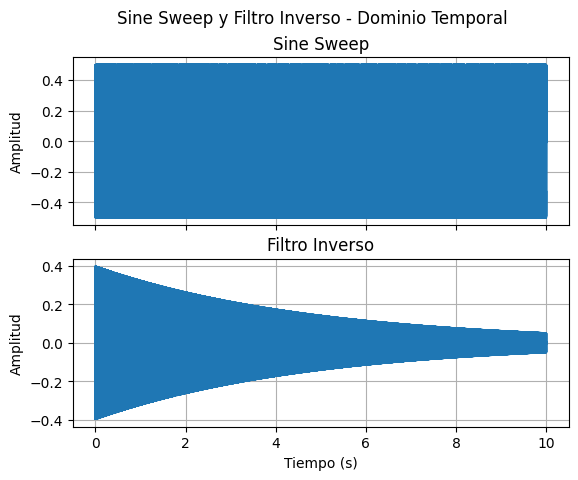

In [4]:
generarSineSweepYFiltroInverso(1000, 8000, 10)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

(500, 15000)

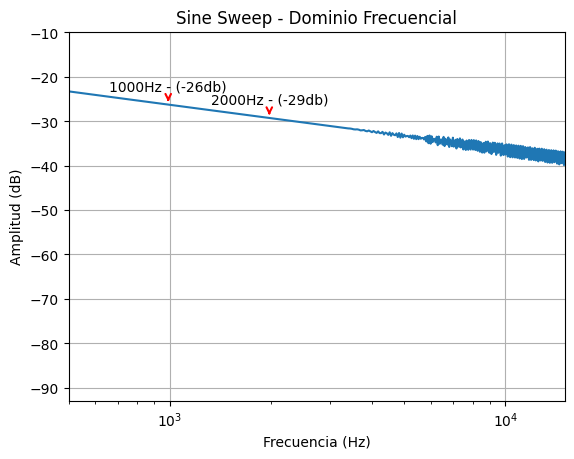

In [33]:
# Grafico el Sine Sweep en el dominio frecuencial

fSineSweep = pd.read_csv("media/espectro-sine-sweep.txt", sep='\t', skiprows=1, header=None)

plt.show()

fig, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(dfSineSweep.iloc[:, 0], dfSineSweep.iloc[:, 1])
ax1.set_ylabel('Amplitud (dB)')
ax1.set_title('Sine Sweep - Dominio Frecuencial')
ax1.grid(True)

plt.xlabel('Frecuencia (Hz)')
plt.xscale('log')
plt.annotate("1000Hz - (-26db)", (990.527344, -26.247152), textcoords="offset points", xytext=(0, 10), ha='center', arrowprops=dict(arrowstyle="->", color='red', lw=1.5))
plt.annotate("2000Hz - (-29db)", (1981.054688, -29.259508), textcoords="offset points", xytext=(0, 10), ha='center', arrowprops=dict(arrowstyle="->", color='red', lw=1.5))
plt.xlim(500,15000)
#plt.ylim(-30,-25)

(500, 15000)

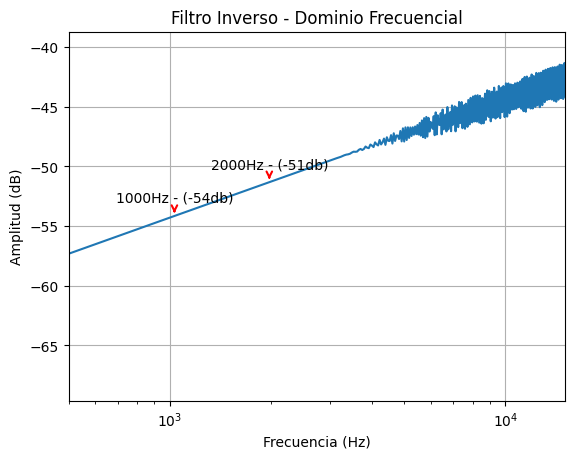

In [34]:
# Grafico el Filtro Inverso en el dominio frecuencial

dfFiltroInverso = pd.read_csv("media/espectro-filtro-inverso.txt", sep='\t', skiprows=1, header=None)

plt.show()

fig, (ax2) = plt.subplots(1, 1, sharex=True)
ax2.plot(dfFiltroInverso.iloc[:, 0], dfFiltroInverso.iloc[:, 1])
ax2.set_ylabel('Amplitud (dB)')
ax2.set_title('Filtro Inverso - Dominio Frecuencial')
ax2.grid(True)

plt.xlabel('Frecuencia (Hz)')
plt.xscale('log')
plt.annotate("1000Hz - (-54db)", (1033.593750, -54.160511), textcoords="offset points", xytext=(0, 10), ha='center', arrowprops=dict(arrowstyle="->", color='red', lw=1.5))
plt.annotate("2000Hz - (-51db)", (1981.054688, -51.331120), textcoords="offset points", xytext=(0, 10), ha='center', arrowprops=dict(arrowstyle="->", color='red', lw=1.5))
plt.xlim(500,15000)
#plt.ylim(-55,-50)

Reproducir resultados.

In [35]:
# Reproducir sine sweep
data, samplerate = sf.read('media/sine-sweep.wav')
sd.play(data, samplerate)
sd.wait()

# Reproducir filtro inverso
data, samplerate = sf.read('media/filtro-inverso.wav')
sd.play(data, samplerate)
sd.wait()

## Función adquisicion y reproducción
**Consigna**: la función tiene que permitir la reproducción y la adquisición de manera simultánea para un tiempo determinado por el usuario. Es importante evaluar y constatar dicha simultaneidad. El módulo debería permitir seleccionar el hardware a utilizar. Algunos articulos de interes para el desarrollo:
* [Clase de audio](../../clases/clase_6/600_audio.ipynb)
* [Sound Device - Simultaneous Playback and Recording](https://python-sounddevice.readthedocs.io/en/0.4.1/usage.html#simultaneous-playback-and-recording)
* [Playing and Recording Sound in Python](https://realpython.com/playing-and-recording-sound-python/)
* [Audio in Python](https://wiki.python.org/moin/Audio/)
* [https://github.com/spatialaudio/python-sounddevice/issues/148](https://github.com/spatialaudio/python-sounddevice/issues/148)

In [1]:
def adquisicion_reproduccion():

    """
    Realiza la adquisición y reproducción simultánea de audio durante un tiempo determinado.

    Esta función permite grabar audio desde un dispositivo de entrada seleccionado por el usuario
    y reproducirlo simultáneamente en un dispositivo de salida también seleccionado por el usuario.

    ¿Cómo lo hace?:
        * Imprime en la consola los dispositivos de audio disponibles y solicita al usuario que 
            seleccione los dispositivos de entrada y salida deseados.
        * Reproduce el audio grabado a través del dispositivo de salida seleccionado.
        
    """

    pyaudio_instance = pyaudio.PyAudio()
    device_count = pyaudio_instance.get_device_count()

    print("Dispositivos de audio disponibles:")
    for i in range(device_count):
        device_info = pyaudio_instance.get_device_info_by_index(i)
        print(f"{i}: {device_info['name']}")


    selected_input_device_index = int(input("Selecciona el número del dispositivo de entrada de audio: "))
    selected_input_device = pyaudio_instance.get_device_info_by_index(selected_input_device_index)

    selected_output_device_index = int(input("Selecciona el número del dispositivo de salida de audio: "))
    selected_output_device = pyaudio_instance.get_device_info_by_index(selected_output_device_index)

    seconds = int(input("Ingrese la cantidad de segundos para la duración de la experiencia de adquisicion y reproducción: "))

    input_stream = pyaudio_instance.open(
        channels=1,   
        format=pyaudio.paInt16, 
        input=True, 
        input_device_index=selected_input_device_index, 
        rate=int(selected_input_device['defaultSampleRate']), 
        frames_per_buffer=1024
    )

    output_stream = pyaudio_instance.open(
        channels=1,   
        format=pyaudio.paInt16, 
        output=True,
        input=True, 
        output_device_index=selected_output_device_index, 
        rate=int(selected_output_device['defaultSampleRate']), 
        frames_per_buffer=1024
    )

    # Prueba de latencia
    
    inputFrames = []
    outputFrames = []

    for i in range(0, int(selected_input_device['defaultSampleRate'] / 1024 * seconds)):
        inputData = input_stream.read(1024)
        output_stream.write(inputData)
        outputData = output_stream.read(1024)

        inputFrames.append(inputData)
        outputFrames.append(outputData)

    input_stream.stop_stream()
    input_stream.close()

    output_stream.stop_stream()
    output_stream.close()
    
    pyaudio_instance.terminate()

    wfInput = wave.open("media/input.wav", 'wb')
    wfInput.setnchannels(1)
    wfInput.setsampwidth(pyaudio_instance.get_sample_size(pyaudio.paInt16))
    wfInput.setframerate(selected_input_device['defaultSampleRate'])
    wfInput.writeframes(b''.join(inputFrames))
    wfInput.close()

    wfOutput = wave.open("media/output.wav", 'wb')
    wfOutput.setnchannels(1)
    wfOutput.setsampwidth(pyaudio_instance.get_sample_size(pyaudio.paInt16))
    wfOutput.setframerate(selected_input_device['defaultSampleRate'])
    wfOutput.writeframes(b''.join(outputFrames))
    wfOutput.close()


Llamar la función.

In [3]:
adquisicion_reproduccion()

Dispositivos de audio disponibles:
0: Microsoft Sound Mapper - Input
1: Microphone (HD Pro Webcam C920)
2: Microphone (Scarlett 2i2 USB)
3: Microsoft Sound Mapper - Output
4: Speakers (Scarlett 2i2 USB)
5: Speakers (Realtek USB2.0 Audio)
6: 2D FHD LG TV (NVIDIA High Defin
7: SPDIF Interface (Realtek USB2.0
8: Primary Sound Capture Driver
9: Microphone (HD Pro Webcam C920)
10: Microphone (Scarlett 2i2 USB)
11: Primary Sound Driver
12: Speakers (Scarlett 2i2 USB)
13: Speakers (Realtek USB2.0 Audio)
14: 2D FHD LG TV (NVIDIA High Definition Audio)
15: SPDIF Interface (Realtek USB2.0 Audio)
16: Speakers (Realtek USB2.0 Audio)
17: 2D FHD LG TV (NVIDIA High Definition Audio)
18: Speakers (Scarlett 2i2 USB)
19: SPDIF Interface (Realtek USB2.0 Audio)
20: Microphone (Scarlett 2i2 USB)
21: Microphone (HD Pro Webcam C920)
22: Speakers (Scarlett 2i2 USB)
23: Microphone (Scarlett 2i2 USB)
24: Analog Connector (Realtek USB2.0 Audio)
25: Line (Realtek USB2.0 Audio)
26: Microphone (Realtek USB2.0 Audio

ValueError: invalid literal for int() with base 10: ''

¿Cómo se podría medir la latencia de la función? Agregar un gráfico.

In [38]:
import time

def latencia():
    inicio = time.time()
    adquisicion_reproduccion()
    fin = time.time()
    latencia = fin - inicio
    print(f"La latencia de la función es de {latencia} segundos")

latencia()

Dispositivos de audio disponibles:
0: Asignador de sonido Microsoft - Input
1: MicrÃ³fono (Realtek(R) Audio)
2: Asignador de sonido Microsoft - Output
3: Auriculares (Realtek(R) Audio)
4: Altavoces (Realtek(R) Audio)
5: Controlador primario de captura de sonido
6: MicrÃ³fono (Realtek(R) Audio)
7: Controlador primario de sonido
8: Auriculares (Realtek(R) Audio)
9: Altavoces (Realtek(R) Audio)
10: Auriculares (Realtek(R) Audio)
11: Altavoces (Realtek(R) Audio)
12: MicrÃ³fono (Realtek(R) Audio)
13: Auriculares con micrÃ³fono (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(TOPHOUSE BS30))
14: Auriculares con micrÃ³fono (@System32\drivers\bthhfenum.sys,#2;%1 Hands-Free%0
;(TOPHOUSE BS30))
15: Speakers 1 (Realtek HD Audio output with SST)
16: Speakers 2 (Realtek HD Audio output with SST)
17: Altavoz de PC (Realtek HD Audio output with SST)
18: Mezcla estÃ©reo (Realtek HD Audio Stereo input)
19: MicrÃ³fono (Realtek HD Audio Mic input)
20: Headphones 1 (Realtek HD Audio 2nd output with S